<a href="https://colab.research.google.com/github/harald-gen01/generatia_play/blob/main/multi_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot

In [ ]:
!pip install > /dev/null 2>&1 \
            langchain \
            langchain-openai \
            langgraph \
            langsmith \
            httpx \
            tavily-python \
            langchain-community \
            langchain_experimental


In [ ]:
import os

In [ ]:
from google.colab import userdata

# Retrieve and set the OpenAI API key
OPENAI_API_KEY = userdata.get('openai_api_key')
TAVILY_API_KEY = userdata.get('tavily_api_key')

LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
LANGCHAIN_TRACING_V2 = userdata.get('LANGCHAIN_TRACING_V2')
LANGCHAIN_PROJECT = userdata.get('LANGCHAIN_PROJECT')

Create tools.
Make an agent to do web research with a search engine, and one agent to create plots.

In [ ]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

Helper Utilities. Helper function below, to make it easier to add new agent worker nodes

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

Function that we will use to be the nodes in the graph. It takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

Create Agent Supervisor. It will use function calling to choose the next worker node OR finish processing.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "cloud_architect"]
system_prompt = (
    "You are a manager tasked with managing a conversation between the"
    " following colleagues:  {members}. Given the following user request,"
    " respond with the worker to act next. Each colleague will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

Construct Graph. We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [ ]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="cloud_architect")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("cloud_architect", code_node)
workflow.add_node("manager", supervisor_chain)

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "manager")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("manager", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.set_entry_point("manager")

graph = workflow.compile()

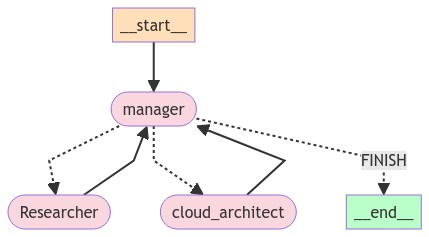

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import BaseMessage

def main():
    while True:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        for event in graph.stream({"messages": [("user", user_input)]}):
            print(event)  # Print the entire event
            print("----")  # Separator
            for value in event.values():
                if "messages" in value and isinstance(value["messages"][-1], BaseMessage):
                    print("Assistant:", value["messages"][-1].content)

if __name__ == "__main__":
    main()